#### Librerias

In [53]:
import json
import os
from pathlib import Path
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import set_config as sk_set_config
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    auc,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from xgboost import XGBClassifier

#### Opciones

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)
sk_set_config(transform_output="pandas")

#### Variables

In [3]:
DATA_PATH: Path = Path("../data")
SEED: int = 1399

#### Cargar datos

In [4]:
df: pd.DataFrame = pd.read_parquet(path=DATA_PATH / "data.parquet.gzip", engine="fastparquet", index="id")
print(f"Filas: {df.shape[0]:,}, Columnas: {df.shape[1]:,}")
df.head()

Filas: 100,000, Columnas: 56


,warranty,sub_status,condition,deal_ids,base_price,seller_id,listing_type_id,price,buying_mode,parent_item_id,category_id,descriptions,last_updated,official_store_id,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,initial_quantity,start_time,permalink,sold_quantity,available_quantity,state.name,n_pictures,tags__dragged_bids_and_visits,tags__dragged_visits,tags__free_relist,tags__good_quality_thumbnail,tags__poor_quality_thumbnail,shipping__local_pick_up,shipping__tags,shipping__free_shipping,shipping__mode,non_mercado_pago_payment_methods__acordar_con_el_comprador,non_mercado_pago_payment_methods__american_express,non_mercado_pago_payment_methods__cheque_certificado,non_mercado_pago_payment_methods__contra_reembolso,non_mercado_pago_payment_methods__diners,non_mercado_pago_payment_methods__efectivo,non_mercado_pago_payment_methods__giro_postal,non_mercado_pago_payment_methods__mastercard,non_mercado_pago_payment_methods__mastercard_maestro,non_mercado_pago_payment_methods__mercadopago,non_mercado_pago_payment_methods__tarjeta_de_crédito,non_mercado_pago_payment_methods__transferencia_bancaria,non_mercado_pago_payment_methods__visa,non_mercado_pago_payment_methods__visa_electron
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MLA4695330653,None,NaN,new,None,80.0,8208882349,bronze,80.0,buy_it_now,MLA6553902747,MLA126406,MLA4695330653-912855983,2015-09-05 20:42:58+00:00,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05 20:42:53+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-04 20:42:53,active,None,NaN,1,2015-09-05 20:42:53,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,Capital Federal,2,1,0,0,0,0,True,None,False,not_specified,1,0,0,0,0,1,0,0,0,0,0,1,0,0
MLA7160447179,NUESTRA REPUTACION,NaN,used,None,2650.0,8141699488,silver,2650.0,buy_it_now,MLA7727150374,MLA10267,MLA7160447179-930764806,2015-09-26 18:08:34+00:00,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26 18:08:30+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-25 18:08:30,active,None,NaN,1,2015-09-26 18:08:30,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,Capital Federal,6,0,0,0,0,0,True,None,False,me2,0,0,0,0,0,1,0,0,0,0,0,1,0,0
MLA7367189936,None,NaN,used,None,60.0,8386096505,bronze,60.0,buy_it_now,MLA6561247998,MLA1227,MLA7367189936-916478256,2015-09-09 23:57:10+00:00,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09 23:57:07+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-08 23:57:07,active,None,NaN,1,2015-09-09 23:57:07,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,Capital Federal,1,1,0,0,0,0,True,None,False,me2,0,0,0,0,0,1,0,0,0,0,1,1,0,0
MLA9191625553,None,NaN,new,None,580.0,5377752182,silver,580.0,buy_it_now,None,MLA86345,MLA9191625553-932309698,2015-10-05 16:03:50.306000+00:00,NaN,True,NaN,ARS,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28 18:47:56+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-12-04 01:13:16,active,None,NaN,1,2015-09-28 18:47:56,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1,Capital Federal,2,0,0,0,0,0,True,None,False,me2,0,0,0,0,0,1,0,0,0,0,1,1,0,0
MLA7787961817,MI REPUTACION.,NaN,used,None,30.0,2938071313,bronze,30.0,buy_it_now,MLA3133256685,MLA41287,MLA7787961817-902981678,2015-08-28 13:37:41+00:00,NaN,True,NaN,ARS,http://mla-s2-p.mlstatic.com/13595-MLA77879618...,Serenata - Jennifer Blake,False,2015-08-24 22:07:20+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-10-23 22:07:20,active,None,NaN,1,2015-08-24 22:07:20,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1,Buenos Aires,2,1,0,0,0,0,True,None,False,not_

En primer lugar, reemplazamos las columnas de tipo booleano por enteros, y corregimos tipo de dato de `shipping__tag` y `shipping__mode`

In [5]:
df = df.astype({col: int for col in df.select_dtypes(include="bool").columns})
df = df.astype({col: "category" for col in ["shipping__tags", "shipping__mode"]})

De acuerdo al analisis descriptivo realizado en el notebook anterior, se van a descartar las siguientes variables:

In [6]:
TO_DROP: list = [
    "catalog_product_id",
    "category_id",
    "deal_ids",
    "descriptions",
    "last_updated",
    "official_store_id",
    "parent_item_id",
    "permalink",
    "secure_thumbnail",
    "seller_id",
    "start_time",
    "stop_time",
    "thumbnail",
    "video_id",
]

- Se intenta recuperar la informacion de las categorias y descripciones.

In [7]:
# Categorias
top5_categories: list = df["category_id"].value_counts().nlargest(5).index.tolist()
category_names: list = []
for cat in top5_categories:
    url: str = f"https://api.mercadolibre.com/categories/{cat}"
    headers: dict[str, str] = {"Authorization": f"Bearer {os.getenv('ML_ACCESS_KEY')}"}
    response: requests.Response = requests.get(url, headers=headers)
    if response.status_code == 404:
        category_names.append(response.json()["message"])
    else:
        category_names.append(response.json()["name"])
category_names

['Otros',
 'Category not found: MLA2044',
 'Category not found: MLA41287',
 'Otros',
 'Category not found: MLA2038']

In [8]:
# Items
first_5_items: list = df.index.tolist()[:5]
item_descriptions: list = []
for item in first_5_items:
    url: str = f"https://api.mercadolibre.com/items/{item}/description"
    headers: dict[str, str] = {"Authorization": f"Bearer {os.getenv('ML_ACCESS_KEY')}"}
    response: requests.Response = requests.get(url, headers=headers)
    if response.status_code == 404:
        item_descriptions.append(response.json()["message"])
    else:
        item_descriptions.append(response.json()["name"])
item_descriptions

['Description of item with id MLA4695330653 not found',
 'Description of item with id MLA7160447179 not found',
 'Description of item with id MLA7367189936 not found',
 'Description of item with id MLA9191625553 not found',
 'Description of item with id MLA7787961817 not found']

- No se puede enriquecer la data a traves del API entonces se procede a eliminar las variables mencionadas anteriormente.

In [9]:
# Se crea separa en X y y
X, y = df.drop(columns=TO_DROP + ["condition"]), df["condition"]
X.shape, y.shape

((100000, 41), (100000,))

- Se divide en entrenamiento y prueba. Se usan 10 mil filas para test de acuerdo con el codigo original:
```
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000 <---------------
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test
```

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 41), (20000, 41), (80000,), (20000,))

- Codificamos la variable Y:

In [11]:
le = LabelEncoder()
y_train, y_test = le.fit_transform(y_train), le.transform(y_test)
le.classes_, le.transform(le.classes_)

(array(['new', 'used'], dtype=object), array([0, 1]))

#### Baseline
- Empezamos unicamente con variables numericas y categoricas. Obviamos las cadenas de texto y las fechas.
- Usaremos un `OrdinalEncoder()` para tratar las varaibles categoricas. Se descarta OHE, al menos para el modelo base, ya que iniciamos con ~40 features.

In [12]:
ct_config = {"remainder": "passthrough", "verbose_feature_names_out": False, "n_jobs": -1}

In [13]:
drop_dates_str_transformer = make_column_transformer(
    ("drop", make_column_selector(dtype_exclude=["number", "category"])), **ct_config
)

ordinal_encoder = OrdinalEncoder(
    min_frequency=0.1, handle_unknown="use_encoded_value", unknown_value=np.nan
)  # Usamos min_freq para categorias con menos de 1000 filas.
ordinal_encoder_transformer = make_column_transformer(
    (ordinal_encoder, make_column_selector(dtype_include="category")), **ct_config
)

clf = XGBClassifier(n_estimators=100, objective="binary:logistic", random_state=SEED, n_jobs=-1)

pipe = Pipeline(steps=[("dropper", drop_dates_str_transformer), ("category", ordinal_encoder), ("clf", clf)])

In [14]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   1.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


In [15]:
train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

In [16]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]
preds = pipe.predict(X_test)

In [17]:
test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

In [18]:
metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,91.81500,78.777000,86.909000,82.643000,0.352740,0.114550
cv,91.11700,78.146000,86.168000,81.961000,0.368750,0.119260
test,82.91286,78.607457,85.942907,82.111679,0.365683,0.118291


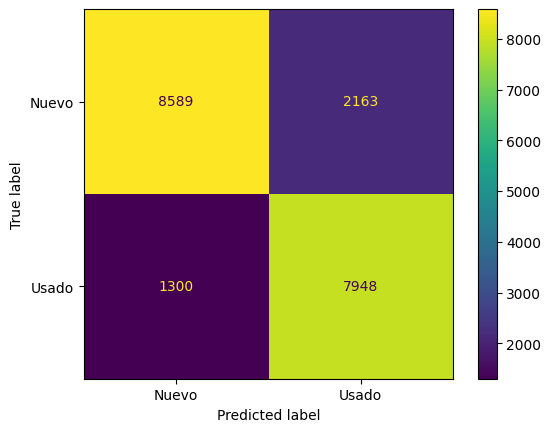

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=["Nuevo", "Usado"])
plt.show()

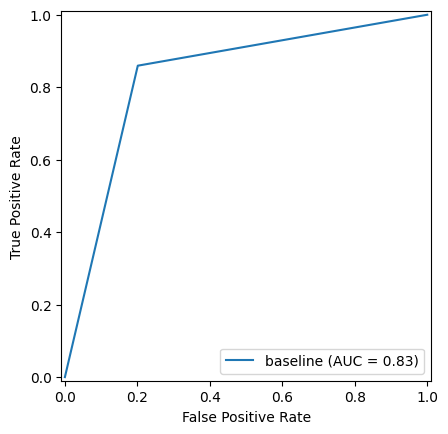

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="baseline")
display.plot()
plt.show()

- El modelo baseline muestra un buen rendimiento general, con una buena capacidad para distinguir entre elementos nuevos y usados. Sin embargo, presenta signos leves de overfitting y podría beneficiarse de una mejor calibración de probabilidades, especialmente en datos no vistos.

#### Feature Selection
Analizaremos y seleccionaremos las mejores variables encontradas.

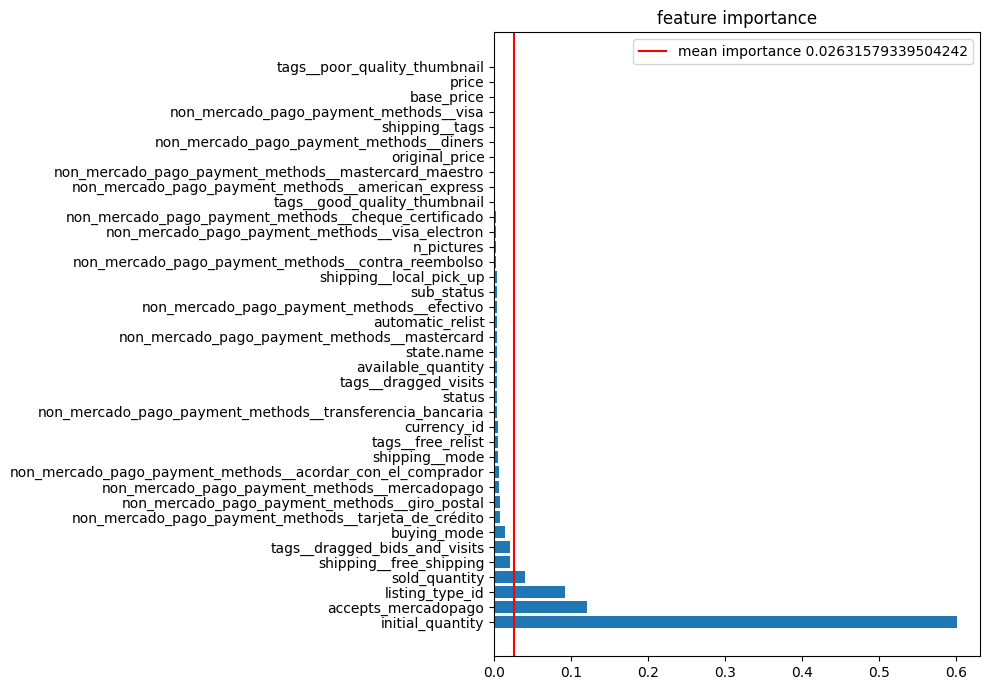

In [21]:
plt.figure(figsize=(10, 7))
feature_importances = dict(zip(pipe[:-1].get_feature_names_out(), pipe[-1].feature_importances_))
sorted_features = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))
plt.barh(y=list(sorted_features.keys()), width=sorted_features.values())
plt.axvline(
    np.mean(list(sorted_features.values())),
    color="red",
    label=f"mean importance {np.mean(list(sorted_features.values()))}",
)
plt.title("feature importance")
plt.tight_layout()
plt.legend()
plt.show()

 - Vemos que la variable mas relevante es `initial_quantity`. Esto puede deberse a que si son productos usados, tiene sentido a que solo tenga una unidad a la venta, ya que no es el fabricante directo. Por otro lado, si es el fabricante, tendra mas Stock y por ende mas unidades a la venta.
 - Seguido de esto, las variables mas importantes son `accept_mercadopago`, `listing_type_id`, `sold_quantity` y `buying_mode`.

Se procedera a utilizar el top 10 de variables mas importantes:

In [22]:
selected_features = (
    pd.DataFrame.from_dict(sorted_features, orient="index", columns=["fe"]).nlargest(n=10, columns="fe").index.tolist()
)
print(f"Variables Seleccionadas: [{', '.join(selected_features)}]")

Variables Seleccionadas: [initial_quantity, accepts_mercadopago, listing_type_id, sold_quantity, shipping__free_shipping, tags__dragged_bids_and_visits, buying_mode, non_mercado_pago_payment_methods__tarjeta_de_crédito, non_mercado_pago_payment_methods__giro_postal, non_mercado_pago_payment_methods__mercadopago]


In [23]:
selector_ct = make_column_transformer(("passthrough", selected_features), remainder="drop", verbose_feature_names_out=False)
pipe = Pipeline(steps=[("selector", selector_ct), ("category", ordinal_encoder), ("clf", clf)])

In [24]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [25]:
train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

In [26]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]
preds = pipe.predict(X_test)

In [27]:
test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

In [28]:
metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,89.580000,74.404000,89.693000,81.33600,0.38934,0.127060
cv,89.543000,74.405000,89.690000,81.33500,0.39063,0.127270
test,81.483786,74.395179,89.446367,81.22944,0.38943,0.126972


#### Mes de posteo

In [29]:
def get_months(df: pd.DataFrame):
    return df["date_created"].dt.month_name().rename("month_posted").to_frame()


get_months_transformer = make_column_transformer((FunctionTransformer(func=get_months), ["date_created"]), **ct_config)

In [30]:
selector_ct = make_column_transformer(
    ("passthrough", selected_features + ["month_posted"]), remainder="drop", verbose_feature_names_out=False
)
pipe = Pipeline(steps=[("month", get_months_transformer), ("selector", selector_ct), ("category", ordinal_encoder), ("clf", clf)])

In [31]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


In [32]:
train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

In [33]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]
preds = pipe.predict(X_test)

In [34]:
test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

In [35]:
metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,89.771000,74.729000,89.048000,81.256000,0.387150,0.126380
cv,89.675000,74.665000,88.979000,81.193000,0.389870,0.126940
test,81.516982,74.404601,89.522059,81.266258,0.388429,0.126545


- No parece que la nueva variable (codificada con OrdinalEncoder) funcione bien.

#### OneHotEncoder

In [36]:
ohe_ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include="category")), **ct_config
)
selector_ct = make_column_transformer(("passthrough", selected_features), remainder="drop", verbose_feature_names_out=False)

pipe = Pipeline(steps=[("selector", selector_ct), ("category", ohe_ct), ("clf", clf)])

In [37]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


In [38]:
train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

In [39]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]
preds = pipe.predict(X_test)

In [40]:
test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

In [41]:
metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,89.830000,74.39500,89.774000,81.36400,0.380710,0.125650
cv,89.702000,74.37200,89.747000,81.33800,0.385700,0.126280
test,81.486811,74.37764,89.489619,81.23681,0.384955,0.126043


- Ligera mejora sobre OrdinalEncoder

#### CategoryID (a pesar de no tener su match) y Provincia:
Se incluyen las dos variables con una codificacion diferente ya que tienen alta cardinalidad

In [42]:
X_train_augmented = X_train.merge(right=df[["category_id"]], right_index=True, left_index=True)
X_test_augmented = X_test.merge(right=df[["category_id"]], right_index=True, left_index=True)

In [43]:
high_cardinality = ["category_id", "state.name"]
low_cardinality = ["listing_type_id", "buying_mode"]

In [44]:
target_encoder = TargetEncoder(random_state=SEED)

In [45]:
high_cardinality_transformer = make_column_transformer((target_encoder, high_cardinality), **ct_config)
ohe_ct = make_column_transformer((OneHotEncoder(sparse_output=False, handle_unknown="ignore"), low_cardinality), **ct_config)
selector_ct = make_column_transformer(
    ("passthrough", selected_features + high_cardinality), remainder="drop", verbose_feature_names_out=False
)

pipe = Pipeline(
    steps=[("selector", selector_ct), ("category", ohe_ct), ("hg_category", high_cardinality_transformer), ("clf", clf)]
)

In [46]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train_augmented,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


In [47]:
train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

In [48]:
pipe.fit(X_train_augmented, y_train)
probs = pipe.predict_proba(X_test_augmented)[:, 1]
preds = pipe.predict(X_test_augmented)

In [49]:
test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

In [50]:
metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,96.107000,86.735000,90.775000,88.689000,0.25045,0.07689
cv,94.463000,84.934000,88.020000,86.422000,0.29767,0.09244
test,87.635438,85.189425,88.505623,86.815868,0.29050,0.08978


- Se obtiene un AUC por encima de 0.86 para todos los sets. Ahora se procede a hacer un fine tuning de los hiperparametros de XGBoost

#### Fine tuning de hiperparametros

In [51]:
search_spaces = {
    "clf__n_estimators": Integer(100, 1000),
    "clf__max_depth": Integer(3, 10),
    "clf__min_child_weight": Integer(3, 10),
    "clf__learning_rate": Real(0.001, 0.1, prior="log-uniform"),
    "clf__subsample": Real(0.6, 1.0),
    "clf__colsample_bytree": Real(0.6, 1.0),
    "clf__gamma": Real(0.1, 1.0, prior="log-uniform"),
    "clf__reg_alpha": Real(0.1, 1.0, prior="log-uniform"),
    "clf__reg_lambda": Real(0.1, 1.0, prior="log-uniform"),
}

bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="roc_auc",
    random_state=SEED,
    n_jobs=-1,
    verbose=10,
)

In [52]:
%%time
bayes_search.fit(X_train_augmented, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START clf__colsample_bytree=0.7376374858095841, clf__gamma=0.19652920031260282, clf__learning_rate=0.0804453262965968, clf__max_depth=8, clf__min_child_weight=6, clf__n_estimators=439, clf__reg_alpha=0.2549116936898428, clf__reg_lambda=0.5773846201906733, clf__subsample=0.91405119434927
[CV 2/5; 1/1] START clf__colsample_bytree=0.7376374858095841, clf__gamma=0.19652920031260282, clf__learning_rate=0.0804453262965968, clf__max_depth=8, clf__min_child_weight=6, clf__n_estimators=439, clf__reg_alpha=0.2549116936898428, clf__reg_lambda=0.5773846201906733, clf__subsample=0.91405119434927
[CV 3/5; 1/1] START clf__colsample_bytree=0.7376374858095841, clf__gamma=0.19652920031260282, clf__learning_rate=0.0804453262965968, clf__max_depth=8, clf__min_child_weight=6, clf__n_estimators=439, clf__reg_alpha=0.2549116936898428, clf__reg_lambda=0.5773846201906733, clf__subsample=0.91405119434927
[CV 4/5; 1/1] START clf__colsample_

/workspaces/mdo-libre/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1399, shuffle=True),
              estimator=Pipeline(steps=[('selector',
                                         ColumnTransformer(transformers=[('passthrough',
                                                                          'passthrough',
                                                                          ['initial_quantity',
                                                                           'accepts_mercadopago',
                                                                           'listing_type_id',
                                                                           'sold_quantity',
                                                                           'shipping__free_shipping',
                                                                           'tags__dragged_bids_and_visits',
                                                                           'buying_mode',
                                                                           'non_mercado_pago_payment_m...
                             'clf__min_child_weight': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.1, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.1, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=10)

In [54]:
print(f"Mejores parametros: {json.dumps(bayes_search.best_params_, indent=4)}")
print(f"Mejore score: {bayes_search.best_score_}")
pipe.set_params(**bayes_search.best_params_)

Mejores parametros: {
    "clf__colsample_bytree": 0.6,
    "clf__gamma": 0.1,
    "clf__learning_rate": 0.020011315724801193,
    "clf__max_depth": 5,
    "clf__min_child_weight": 3,
    "clf__n_estimators": 803,
    "clf__reg_alpha": 0.1,
    "clf__reg_lambda": 0.1,
    "clf__subsample": 0.6
}
Mejore score: 0.9462230536797014


/workspaces/mdo-libre/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['initial_quantity',
                                                   'accepts_mercadopago',
                                                   'listing_type_id',
                                                   'sold_quantity',
                                                   'shipping__free_shipping',
                                                   'tags__dragged_bids_and_visits',
                                                   'buying_mode',
                                                   'non_mercado_pago_payment_methods__tarjeta_de_crédito',
                                                   'non_mercado_pago_payment_methods__giro_postal',
                                                   'non_merca...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.020011315724801193, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=803, n_jobs=-1,
                               num_parallel_tree=None, random_state=1399, ...))])

#### Evaluacion final

In [55]:
cv_result = cross_validate(
    estimator=pipe,
    X=X_train_augmented,
    y=y_train,
    scoring=["roc_auc", "precision", "recall", "f1", "neg_brier_score", "neg_log_loss"],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    return_train_score=True,
    verbose=2,
)

train_roc_auc = round(np.mean(cv_result["train_roc_auc"]), 5) * 100
train_precision = round(np.mean(cv_result["train_precision"]), 5) * 100
train_recall = round(np.mean(cv_result["train_recall"]), 5) * 100
train_f1 = round(np.mean(cv_result["train_f1"]), 5) * 100
train_log_loss = round(np.mean(cv_result["train_neg_log_loss"]), 5) * -1
train_brier_score = round(np.mean(cv_result["train_neg_brier_score"]), 5) * -1


val_roc_auc = round(np.mean(cv_result["test_roc_auc"]), 5) * 100
val_precision = round(np.mean(cv_result["test_precision"]), 5) * 100
val_recall = round(np.mean(cv_result["test_recall"]), 5) * 100
val_f1 = round(np.mean(cv_result["test_f1"]), 5) * 100
val_log_loss = round(np.mean(cv_result["test_neg_log_loss"]), 5) * -1
val_brier_score = round(np.mean(cv_result["test_neg_brier_score"]), 5) * -1

pipe.fit(X_train_augmented, y_train)
probs = pipe.predict_proba(X_test_augmented)[:, 1]
preds = pipe.predict(X_test_augmented)

test_roc_auc = roc_auc_score(y_test, preds) * 100
test_precision = precision_score(y_test, preds) * 100
test_recall = recall_score(y_test, preds) * 100
test_f1 = f1_score(y_test, preds) * 100
test_log_loss = log_loss(y_test, probs)
test_brier_score = brier_score_loss(y_test, probs)

metrics_df = pd.DataFrame.from_dict(
    {
        "ROC_AUC": [train_roc_auc, val_roc_auc, test_roc_auc],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1": [train_f1, val_f1, test_f1],
        "LogLoss": [train_log_loss, val_log_loss, test_log_loss],
        "BrierScore": [train_brier_score, val_brier_score, test_brier_score],
    }
)
metrics_df.index = ["train", "cv", "test"]
metrics_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   4.1s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished


,ROC_AUC,Precision,Recall,F1,LogLoss,BrierScore
train,96.128000,86.254000,91.509000,88.80300,0.250060,0.07633
cv,94.622000,84.670000,89.033000,86.79500,0.292240,0.09066
test,87.775896,85.176739,88.851644,86.97539,0.288066,0.08922


- Se evidencia una ligera mejora de 0.8763 a 0.8777. Se espera que con mas iteraciones en el optimizador de hiperparametros, se consigan mejores resultados.

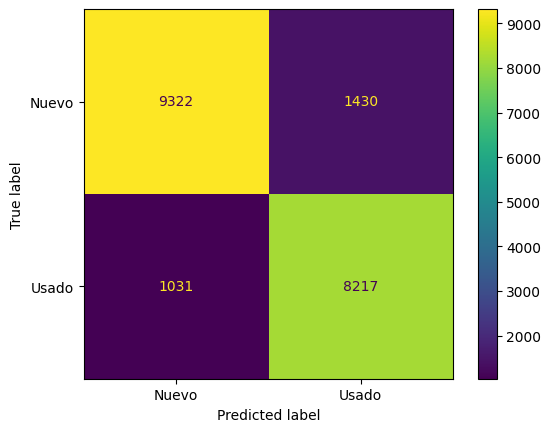

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=["Nuevo", "Usado"])
plt.show()

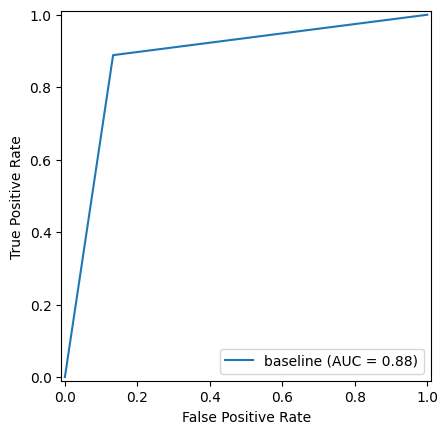

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="baseline")
display.plot()
plt.show()

- Se cumple con la meta del AUC mayor o igual a 0.86

#### Guardar modelo

In [58]:
model_path = Path("../models")
with open(model_path / "model.pkl", "wb") as f:
    dump(pipe, file=f, protocol=5)